In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from collections import defaultdict

from Components.ConditionalNormalDistribution import ConditionalNormalDistribution
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelExponential import ModelExponential
from Models.ModelSinCos import ModelSinCos
from Models.ModelLogistic import ModelLogistic
from Models.ModelSigmoid import ModelSigmoid
from Composition.SequentialSystem import SequentialSystem
from SearchAlgorithm.skeleton import BO_skeleton, BO_graph, BO_graph_local_loss, BO_graph_turbo

from GraphDecomposition.DirectedFunctionalGraph import DirectedFunctionalGraph
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelSinCos import ModelSinCos
from Models.ModelConstant import ModelConstant
from Models.ModelWeightedSum import ModelWeightedSum
from Models.ModelExponential import ModelExponential

%load_ext autoreload
%autoreload 2
from GraphDecomposition.Heuristic import *
from helper import *
from Plotting.HeatMapLossFunction import *



In [2]:
from Models.ModelMNIST import ModelMNIST
from mnist.MNISTLoader import *
from helper import *

ground_truth_param_mnist = {"Blackbox7": np.array([0.8,0.8]), 6 : np.array([0.7, 0.9]), 2: np.array([0.5, 0.7]), 12: np.array([0.5, 0.5]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([-0.3, 0.5]),
                            8 : np.array([0.7, 0.9]), 9 : np.array([-0.7, 0.9]), 10 : np.array([0.7, 0.9]), 11 : np.array([-0.4, 0.8]), 12 : np.array([-0.4, 0.8, 0.1]), 13 : np.array([-0.4, 0.8, 0.1]), 14:np.array([0.5, 0.8])}

ground_truth_param_mnist_original = {"Blackbox7": np.array([0.8,0.8]), 6 : np.array([0.7, 0.9, -0.3]), 2: np.array([0.5, 0.7]), 12: np.array([0.5, 0.5]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([-0.3, 0.5]),
                            8 : np.array([0.7, 0.9]), 9 : np.array([-0.7, 0.9]), 10 : np.array([0.7, 0.9]), 11 : np.array([-0.4, 0.8]), 12 : np.array([-0.4, 0.8, 0.1]), 13 : np.array([-0.4, 0.8, 0.1]), 14:np.array([0.5, 0.8])}


adding edge from nn_1 to 9
adding edge from 11 to 9
adding edge from Blackbox7 to 14
adding edge from 13 to 14
adding edge from 4 to Blackbox7
adding edge from 6 to Blackbox7
adding edge from nn_1 to Blackbox3
adding edge from 2 to Blackbox3
setting:  [0.7 0.9]
setting:  [0.5 0.7]
setting:  [-0.3  0.5]
setting:  [1.2 0.8]
setting:  [0.8 0.8]
setting:  [0.7 0.9]
setting:  [-0.7  0.9]
setting:  [0.7 0.9]
setting:  [-0.4  0.8]
setting:  [-0.4  0.8  0.1]
setting:  [-0.4  0.8  0.1]
setting:  [0.5 0.8]


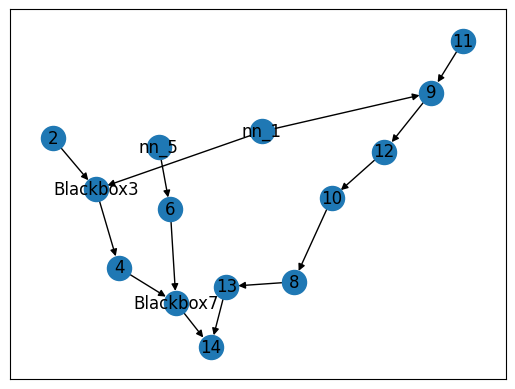

In [5]:

data_generation_seed = 99
bb_component_noise = -0.1
grad_descent_starting_seed = 800

# noises = [-1.0, -0.5, -0.2, 0.2, 0.5, 1.0]
# data_generation_seeds = [99]
# for bb_component_noise in noises:
#     for data_generation_seed in data_generation_seeds:
#         grad_descent_starting_seed = 800
#         dg_nn = create_mnist_system(ground_truth_param_mnist, noise=bb_component_noise, seed=data_generation_seed)
#         #nx.draw_networkx(dg_nn)
#         #grad descent
#         dg_nn.to_perturb = True
#         dg_nn.random_initialize_param(grad_descent_starting_seed)
#         # dg_nn.random_initialize_param(23)
#         lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=500, plot=True)
#         lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
#         print("minimum system loss: ", min(all_loss["system"]))

data_generation_seed = 99
bb_component_noise = 0.3
grad_descent_starting_seed = 800
dg_nn = create_mnist_system(ground_truth_param_mnist, noise=bb_component_noise, seed=data_generation_seed)
dg_nn.to_perturb = True
nx.draw_networkx(dg_nn)
plt.show()



In [7]:
len(dg_nn.get_all_params()[1])

22

In [ ]:
ground_truth_param_mnist_original = {"Blackbox7": np.array([0.8,0.8]), 6 : np.array([0.7, 0.9, -0.3]), 2: np.array([0.5, 0.7]), 12: np.array([0.5, 0.5]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([-0.3, 0.5]),
                            8 : np.array([0.7, 0.9]), 9 : np.array([-0.7, 0.9]), 10 : np.array([0.7, 0.9]), 11 : np.array([-0.4, 0.8]), 12 : np.array([-0.4, 0.8, 0.1]), 13 : np.array([-0.4, 0.8, 0.1]), 14:np.array([0.5, 0.8])}


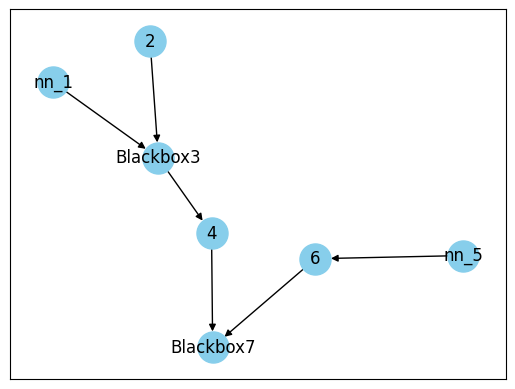

In [4]:
nx.draw_networkx(dg_nn, node_size=500, node_color="skyblue")
plt.show()

In [4]:
dg_nn.system_y

tensor([0.7154, 0.5458, 0.7970, 0.8385, 0.7171, 0.5622, 0.7645, 0.6948, 0.7539,
        0.8397, 0.7216, 0.6316, 0.7416, 0.7317, 0.6605, 0.6177, 0.6882, 0.7879,
        0.7983, 0.7146, 0.5688, 0.5918, 0.6430, 0.7026, 0.7726, 0.6579, 0.5957,
        0.6034, 0.7980, 0.7820, 0.7172, 0.8623, 0.5740, 0.8561, 0.6862, 0.7317,
        0.4605, 0.6193, 0.7288, 0.7164, 0.8315, 0.7006, 0.5198, 0.7540, 0.8438,
        0.7083, 0.6650, 0.5217, 0.6947, 0.8362, 0.5647, 0.8079, 0.7154, 0.6675,
        0.6646, 0.6779, 0.7244, 0.7558, 0.5889, 0.8082, 0.8288, 0.8603, 0.8270,
        0.6901, 0.6887, 0.7421, 0.7978, 0.7393, 0.8122, 0.7215, 0.7202, 0.6180,
        0.7472, 0.8044, 0.7906, 0.6343, 0.7536, 0.6013, 0.6892, 0.9123, 0.6077,
        0.6946, 0.6225, 0.8345, 0.7513, 0.7169, 0.7693, 0.7092, 0.7315, 0.7959,
        0.6061, 0.7287, 0.6897, 0.6268, 0.7822, 0.7691, 0.8255, 0.7276, 0.7509,
        0.6594], dtype=torch.float64)

In [11]:
dg_nn.nodes

NodeView(('nn_1', 'nn_5', 6, 2, 4, 'Blackbox3', 'Blackbox7'))

In [5]:
dg_nn.random_initialize_param(25)
dg_nn.to_perturb = True
print(dg_nn.get_system_loss())
dg_nn.fit_locally_partial(25)
print(dg_nn.get_system_loss())

tensor(0.7120, dtype=torch.float64)
tensor(0.3464, dtype=torch.float64)


final system loss:  tensor(0.1844, dtype=torch.float64)


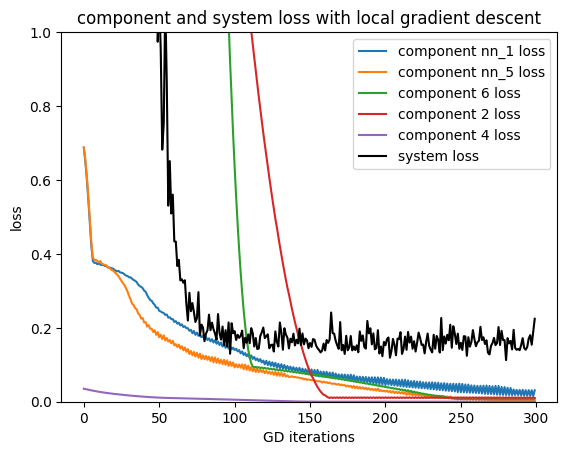

minimum system loss:  tensor(0.1126, dtype=torch.float64)


In [4]:
#grad descent
dg_nn.to_perturb = True
dg_nn.random_initialize_param(5)
dg_nn.noise_std = 0.2
# dg_nn.random_initialize_param(23)
lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
print("minimum system loss: ", min(all_loss["system"]))

# #grad descent
# dg_nn.to_perturb = True
# dg_nn.random_initialize_param(5)
# dg_nn.noise_std = 0.2
# # dg_nn.random_initialize_param(23)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
# lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
# print("minimum system loss: ", min(all_loss["system"]))

# #grad descent
# dg_nn.to_perturb = True
# dg_nn.random_initialize_param(5)
# dg_nn.noise_std = 0.2
# # dg_nn.random_initialize_param(23)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
# lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
# print("minimum system loss: ", min(all_loss["system"]))

# #grad descent
# dg_nn.to_perturb = True
# dg_nn.random_initialize_param(5)
# dg_nn.noise_std = 0.2
# # dg_nn.random_initialize_param(23)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
# lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
# print("minimum system loss: ", min(all_loss["system"]))

# #grad descent
# dg_nn.to_perturb = True
# dg_nn.random_initialize_param(5)
# dg_nn.noise_std = 0.2
# # dg_nn.random_initialize_param(23)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
# lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
# print("minimum system loss: ", min(all_loss["system"]))

In [5]:

lower_bound_local_loss=[0.03090491, 0.00257346, 0.00829136, 0.01019574, 0.00013303]


In [23]:
dg_nn.random_initialize_param()
dg_nn.to_perturb = True
print(dg_nn.get_system_loss())

AttributeError: 'DirectedFunctionalGraph' object has no attribute 'components'

In [ ]:

# vanilla BO
import botorch
import time
botorch.settings.debug = False
botorch.settings.debug


vanilla_all_trials = []
trials = 100
        
for x in range(trials):
    if len(vanilla_all_trials) >= 5:
        break

    now = time.time()
    dg_nn.random_initialize_param(5)
    print(dg_nn.get_system_loss())
    for x in range(100):
        dg_nn.nodes["nn_1"]["component"].do_one_descent_on_local()
        dg_nn.nodes["nn_5"]["component"].do_one_descent_on_local()
    print(dg_nn.get_system_loss())
    #nx.relabel_nodes(dg_nn, {"nn_1" : "Blackbox_1", "nn_5": "Blackbox_5"}, copy=False)
    #all_best_losses, _, _ = BO_graph(dg_nn,printout=True,iteration=20)
    all_best_losses, _, _ = BO_graph_turbo(dg_nn,printout=True,iteration=100,to_normalize_y=True,lower_bound=-1.8, upper_bound=1.8, batch_size=2)
    
    vanilla_all_trials.append(all_best_losses)
    later = time.time()
    difference = (later - now)
    print("total time taken: ", difference)

vanilla_all_trials = np.array(vanilla_all_trials)
np.savetxt("result/mnist_turbo_small_graph_smaller_bound.csv", vanilla_all_trials)

In [ ]:

# vanilla BO
import botorch
import time
botorch.settings.debug = False
botorch.settings.debug


vanilla_all_trials = []
trials = 100
        
for x in range(trials):
    if len(vanilla_all_trials) >= 1:
        break

    now = time.time()
    dg_nn.random_initialize_param(51)
    print(dg_nn.get_system_loss())
    for x in range(100):
        dg_nn.nodes["nn_1"]["component"].do_one_descent_on_local()
        dg_nn.nodes["nn_5"]["component"].do_one_descent_on_local()
    print(dg_nn.get_system_loss())
    #nx.relabel_nodes(dg_nn, {"nn_1" : "Blackbox_1", "nn_5": "Blackbox_5"}, copy=False)
    all_best_losses, _, _ = BO_graph(dg_nn,printout=True,iteration=200)
    
    vanilla_all_trials.append(all_best_losses)
    later = time.time()
    difference = (later - now)
    print("total time taken: ", difference)

vanilla_all_trials = np.array(vanilla_all_trials)
#np.savetxt("result/mnist_vanilla_BO_data_seed_800_starting_grad_seed_99_noise_pos_0.5.csv", vanilla_all_trials)

In [21]:
bounds = torch.tensor([np.array(lower_bound_local_loss) * 1, np.array(lower_bound_local_loss) * 3])
print(bounds)

tensor([[0.0098, 0.0005, 0.0022, 0.0054, 0.0004],
        [0.0293, 0.0015, 0.0065, 0.0162, 0.0013]], dtype=torch.float64)


number of attempts:  0
trial of our BO (successful):  0
BO iteration:  0
Current best objective:  -10000
target loss: tensor([6.7569e-01, 6.7603e-01, 7.3841e+01, 1.8655e+01, 5.6510e+04],
       dtype=torch.float64)
reached loss: tensor([[6.7569e-01, 6.7603e-01, 7.3841e+01, 1.8655e+01, 5.6510e+04]],
       dtype=torch.float64)
candidate param:  tensor([[0.1822, 0.0187, 0.0182, 0.0455, 0.0007]], dtype=torch.float64)
time taken for one BO iteration:  0.38530564308166504
BO iteration:  1
Current best objective:  -10000


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  53.8698570728302
1000


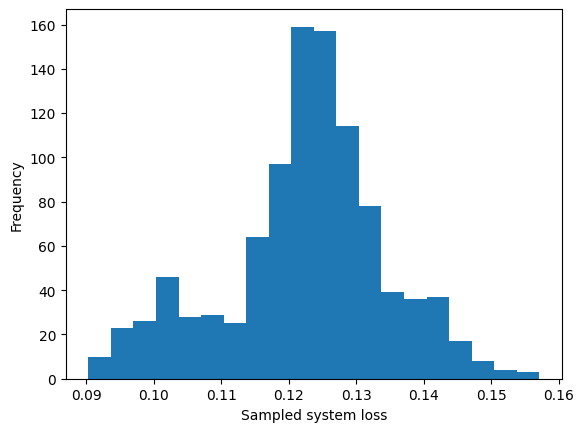

number of system calls:  1000
time taken for system evaluation:  237.36259841918945
best loss:  tensor(0.0903, dtype=torch.float64)
target loss: tensor([0.1822, 0.0187, 0.0182, 0.0455, 0.0007], dtype=torch.float64)
reached loss: tensor([[0.1794, 0.0139, 0.0195, 0.0451, 0.0008]], dtype=torch.float64)
candidate param:  tensor([[0.0411, 0.0241, 0.0124, 0.0322, 0.0003]], dtype=torch.float64)
time taken for one BO iteration:  291.72610545158386
BO iteration:  2
Current best objective:  tensor(-0.0903, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  49.94538998603821
1000


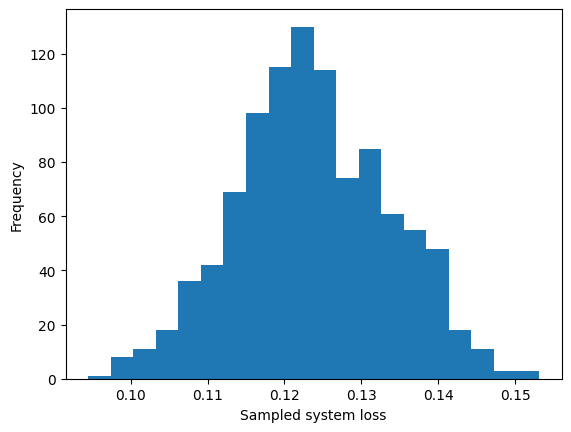

number of system calls:  1000
time taken for system evaluation:  229.21733140945435
best loss:  tensor(0.0945, dtype=torch.float64)
target loss: tensor([0.0411, 0.0241, 0.0124, 0.0322, 0.0003], dtype=torch.float64)
reached loss: tensor([[0.0363, 0.0169, 0.0131, 0.0352, 0.0003]], dtype=torch.float64)
candidate param:  tensor([[0.0740, 0.0124, 0.0715, 0.0350, 0.0003]], dtype=torch.float64)
time taken for one BO iteration:  279.65994691848755
BO iteration:  3
Current best objective:  tensor(-0.0903, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  53.916775941848755
1000


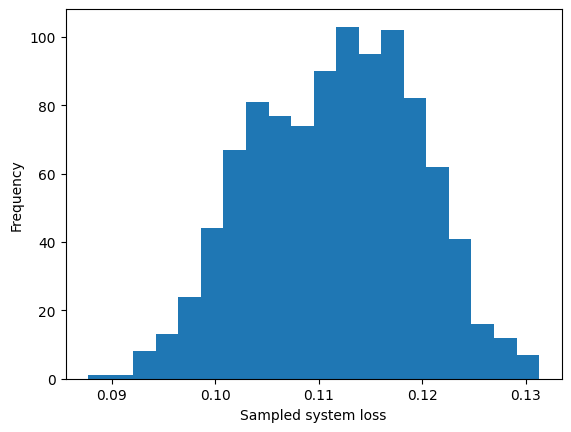

number of system calls:  1000
time taken for system evaluation:  228.93126392364502
best loss:  tensor(0.0877, dtype=torch.float64)
target loss: tensor([0.0740, 0.0124, 0.0715, 0.0350, 0.0003], dtype=torch.float64)
reached loss: tensor([[0.0695, 0.0081, 0.0779, 0.0365, 0.0003]], dtype=torch.float64)
candidate param:  tensor([[0.0951, 0.0130, 0.0368, 0.0389, 0.0005]], dtype=torch.float64)
time taken for one BO iteration:  283.8972735404968
BO iteration:  4
Current best objective:  tensor(-0.0877, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  51.948779821395874
1000


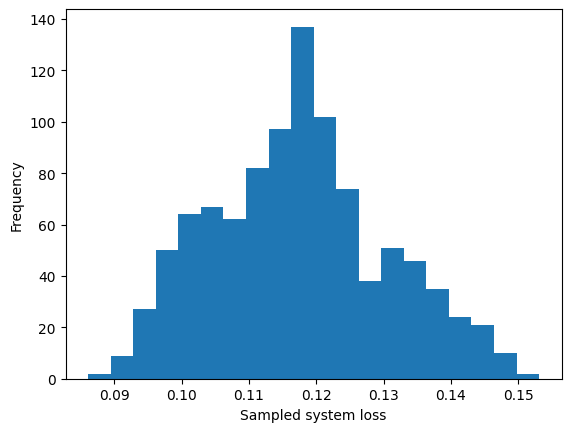

number of system calls:  1000
time taken for system evaluation:  233.8820502758026
best loss:  tensor(0.0861, dtype=torch.float64)
target loss: tensor([0.0951, 0.0130, 0.0368, 0.0389, 0.0005], dtype=torch.float64)
reached loss: tensor([[0.3672, 0.0117, 0.0277, 0.0361, 0.0005]], dtype=torch.float64)
candidate param:  tensor([[0.1184, 0.0114, 0.0353, 0.0511, 0.0010]], dtype=torch.float64)
time taken for one BO iteration:  287.9721529483795
BO iteration:  5
Current best objective:  tensor(-0.0861, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  52.026976108551025
1000


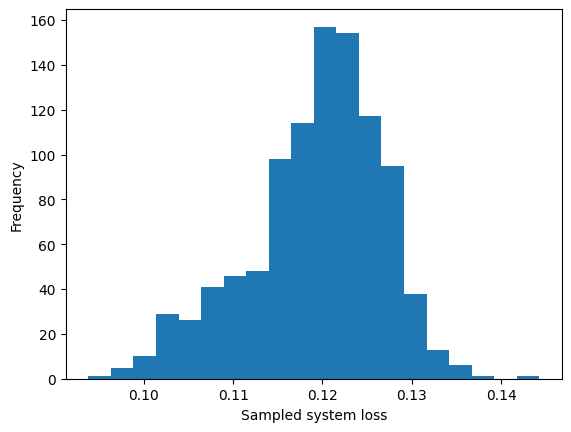

number of system calls:  1000
time taken for system evaluation:  262.9738402366638
best loss:  tensor(0.0938, dtype=torch.float64)
target loss: tensor([0.1184, 0.0114, 0.0353, 0.0511, 0.0010], dtype=torch.float64)
reached loss: tensor([[0.1137, 0.0078, 0.0387, 0.0554, 0.0011]], dtype=torch.float64)
candidate param:  tensor([[0.0856, 0.0117, 0.0354, 0.0417, 0.0009]], dtype=torch.float64)
time taken for one BO iteration:  315.7386431694031
BO iteration:  6
Current best objective:  tensor(-0.0861, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  52.88731074333191
1000


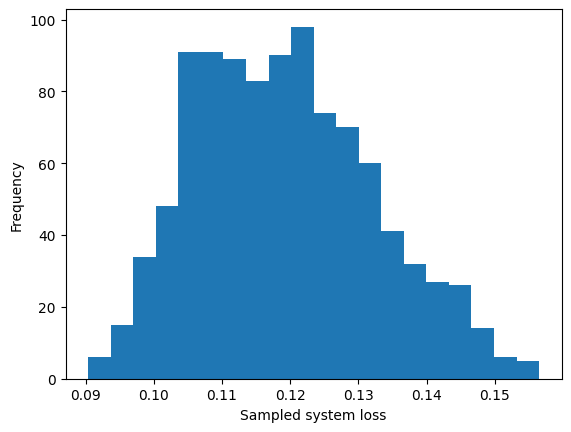

number of system calls:  1000
time taken for system evaluation:  244.76967120170593
best loss:  tensor(0.0904, dtype=torch.float64)
target loss: tensor([0.0856, 0.0117, 0.0354, 0.0417, 0.0009], dtype=torch.float64)
reached loss: tensor([[0.0827, 0.0023, 0.0361, 0.0413, 0.0009]], dtype=torch.float64)
candidate param:  tensor([[0.1458, 0.0253, 0.0456, 0.0388, 0.0013]], dtype=torch.float64)
time taken for one BO iteration:  299.00100660324097
BO iteration:  7
Current best objective:  tensor(-0.0861, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  55.30707836151123
1000


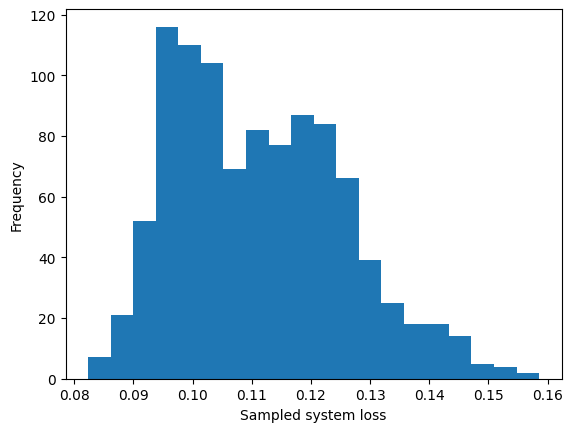

number of system calls:  1000
time taken for system evaluation:  232.8060781955719
best loss:  tensor(0.0824, dtype=torch.float64)
target loss: tensor([0.1458, 0.0253, 0.0456, 0.0388, 0.0013], dtype=torch.float64)
reached loss: tensor([[0.1411, 0.0206, 0.0514, 0.0390, 0.0014]], dtype=torch.float64)
candidate param:  tensor([[0.2089, 0.0211, 0.0390, 0.0723, 0.0007]], dtype=torch.float64)
time taken for one BO iteration:  290.8674147129059
BO iteration:  8
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  51.081554651260376
1000


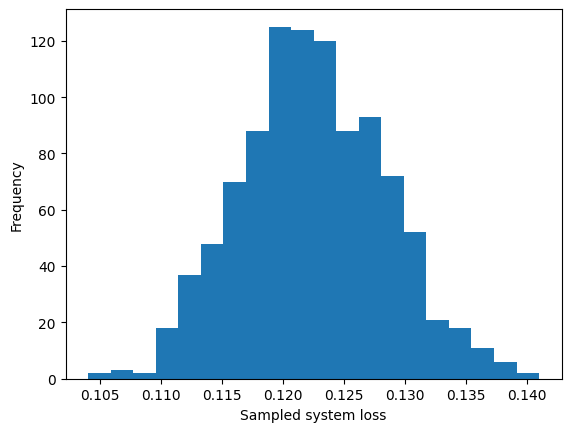

number of system calls:  1000
time taken for system evaluation:  232.27301907539368
best loss:  tensor(0.1040, dtype=torch.float64)
target loss: tensor([0.2089, 0.0211, 0.0390, 0.0723, 0.0007], dtype=torch.float64)
reached loss: tensor([[0.2050, 0.0177, 0.0422, 0.0739, 0.0007]], dtype=torch.float64)
candidate param:  tensor([[0.0785, 0.0108, 0.0754, 0.0487, 0.0006]], dtype=torch.float64)
time taken for one BO iteration:  283.92829418182373
BO iteration:  9
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  49.98790240287781
1000


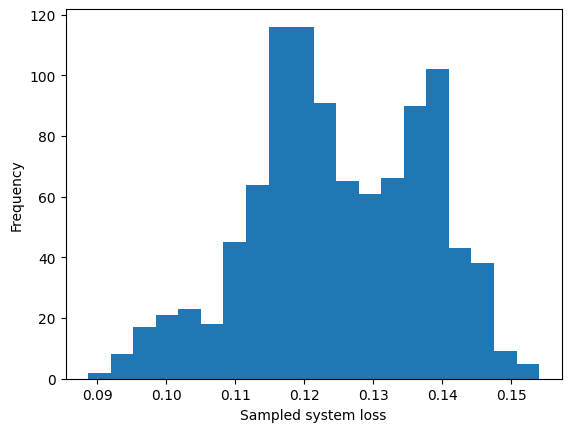

number of system calls:  1000
time taken for system evaluation:  251.167377948761
best loss:  tensor(0.0887, dtype=torch.float64)
target loss: tensor([0.0785, 0.0108, 0.0754, 0.0487, 0.0006], dtype=torch.float64)
reached loss: tensor([[0.0733, 0.3866, 0.0826, 0.0479, 0.0006]], dtype=torch.float64)
candidate param:  tensor([[0.1139, 0.0089, 0.0389, 0.0538, 0.0004]], dtype=torch.float64)
time taken for one BO iteration:  301.7612054347992
BO iteration:  10
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  50.517446517944336
1000


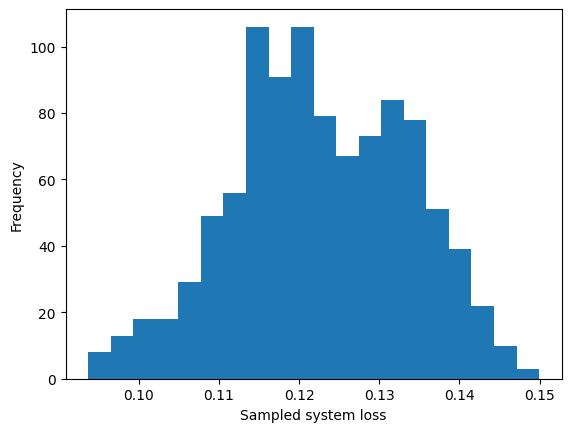

number of system calls:  1000
time taken for system evaluation:  246.44177150726318
best loss:  tensor(0.0937, dtype=torch.float64)
target loss: tensor([0.1139, 0.0089, 0.0389, 0.0538, 0.0004], dtype=torch.float64)
reached loss: tensor([[1.1171e-01, 3.8641e-01, 3.0881e-02, 5.6809e-02, 3.7975e-04]],
       dtype=torch.float64)
candidate param:  tensor([[0.1835, 0.0056, 0.0338, 0.0857, 0.0005]], dtype=torch.float64)
time taken for one BO iteration:  297.3591296672821
BO iteration:  11
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  52.930973291397095
1000


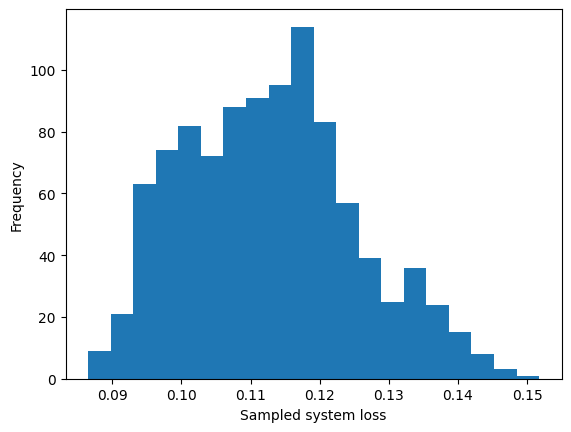

number of system calls:  1000
time taken for system evaluation:  280.80002546310425
best loss:  tensor(0.0865, dtype=torch.float64)
target loss: tensor([0.1835, 0.0056, 0.0338, 0.0857, 0.0005], dtype=torch.float64)
reached loss: tensor([[0.1838, 0.0024, 0.0367, 0.0928, 0.0006]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.3090, 0.0028, 0.0091, 0.1020, 0.0013]], dtype=torch.float64)
time taken for one BO iteration:  334.79820108413696
BO iteration:  12
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  53.274699687957764
1000


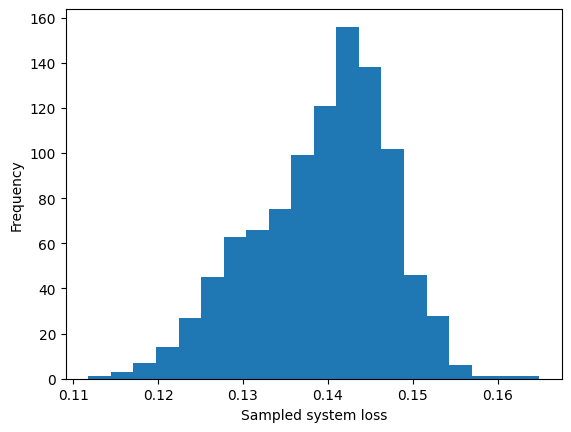

number of system calls:  1000
time taken for system evaluation:  245.07446694374084
best loss:  tensor(0.1118, dtype=torch.float64)
target loss: tensor([0.3090, 0.0028, 0.0091, 0.1020, 0.0013], dtype=torch.float64)
reached loss: tensor([[0.3069, 0.3869, 0.0100, 0.1082, 0.0015]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.3090, 0.0028, 0.0829, 0.1020, 0.0013]], dtype=torch.float64)
time taken for one BO iteration:  299.582261800766
BO iteration:  13
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  52.92934584617615
1000


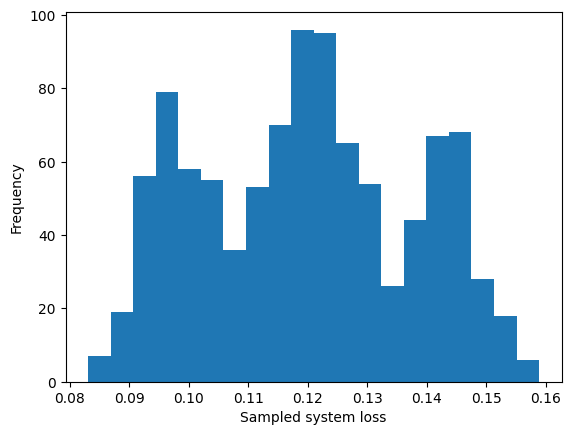

number of system calls:  1000
time taken for system evaluation:  229.57719564437866
best loss:  tensor(0.0831, dtype=torch.float64)
target loss: tensor([0.3090, 0.0028, 0.0829, 0.1020, 0.0013], dtype=torch.float64)
reached loss: tensor([[0.3091, 0.3867, 0.0856, 0.1121, 0.0015]], dtype=torch.float64)
candidate param:  tensor([[0.1138, 0.0200, 0.0699, 0.0877, 0.0013]], dtype=torch.float64)
time taken for one BO iteration:  283.44601917266846
BO iteration:  14
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  53.20190501213074
1000


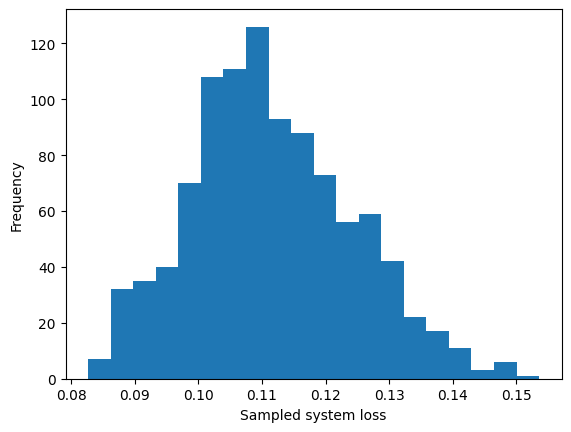

number of system calls:  1000
time taken for system evaluation:  237.55385327339172
best loss:  tensor(0.0826, dtype=torch.float64)
target loss: tensor([0.1138, 0.0200, 0.0699, 0.0877, 0.0013], dtype=torch.float64)
reached loss: tensor([[0.1117, 0.0162, 0.0774, 0.0944, 0.0012]], dtype=torch.float64)
candidate param:  tensor([[0.2148, 0.0040, 0.0510, 0.0365, 0.0012]], dtype=torch.float64)
time taken for one BO iteration:  291.2718529701233
BO iteration:  15
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  54.419883012771606
1000


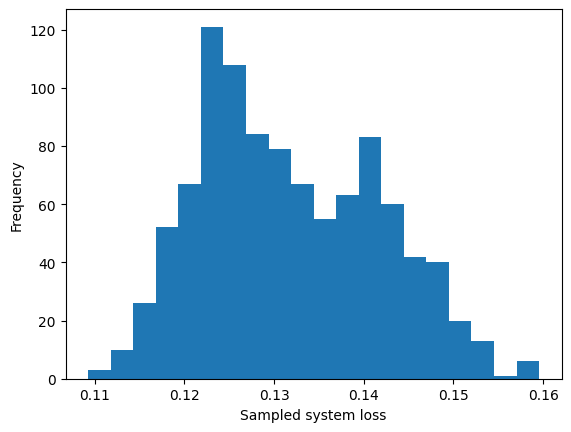

number of system calls:  1000
time taken for system evaluation:  241.59921169281006
best loss:  tensor(0.1093, dtype=torch.float64)
target loss: tensor([0.2148, 0.0040, 0.0510, 0.0365, 0.0012], dtype=torch.float64)
reached loss: tensor([[0.2112, 0.0014, 0.0577, 0.0373, 0.0011]], dtype=torch.float64)
candidate param:  tensor([[0.1167, 0.0155, 0.0575, 0.0530, 0.0006]], dtype=torch.float64)
time taken for one BO iteration:  296.56953477859497
BO iteration:  16
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  51.66334772109985
1000


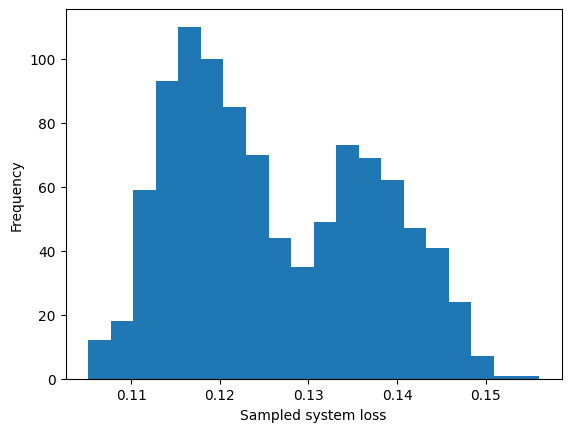

number of system calls:  1000
time taken for system evaluation:  238.0887906551361
best loss:  tensor(0.1052, dtype=torch.float64)
target loss: tensor([0.1167, 0.0155, 0.0575, 0.0530, 0.0006], dtype=torch.float64)
reached loss: tensor([[0.1135, 0.0071, 0.0627, 0.0554, 0.0006]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.3090, 0.0028, 0.0091, 0.1020, 0.0013]], dtype=torch.float64)
time taken for one BO iteration:  291.4628610610962
BO iteration:  17
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  54.83676791191101
1000


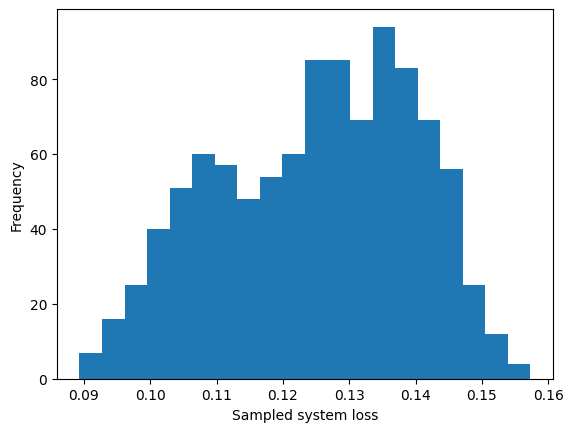

number of system calls:  1000
time taken for system evaluation:  240.40148258209229
best loss:  tensor(0.0893, dtype=torch.float64)
target loss: tensor([0.3090, 0.0028, 0.0091, 0.1020, 0.0013], dtype=torch.float64)
reached loss: tensor([[0.3113, 0.0007, 0.0099, 0.1108, 0.0013]], dtype=torch.float64)
candidate param:  tensor([[0.1758, 0.0257, 0.0448, 0.0644, 0.0009]], dtype=torch.float64)
time taken for one BO iteration:  297.48468232154846
BO iteration:  18
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  51.405290603637695
1000


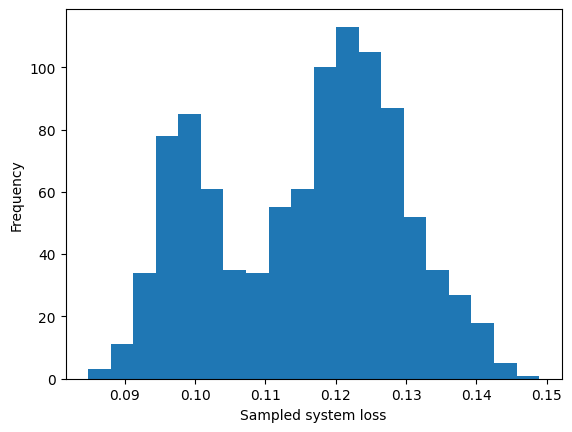

number of system calls:  1000
time taken for system evaluation:  232.21894884109497
best loss:  tensor(0.0848, dtype=torch.float64)
target loss: tensor([0.1758, 0.0257, 0.0448, 0.0644, 0.0009], dtype=torch.float64)
reached loss: tensor([[0.3669, 0.0251, 0.0491, 0.0655, 0.0009]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.0340, 0.0028, 0.0091, 0.0112, 0.0001]], dtype=torch.float64)
time taken for one BO iteration:  284.67966294288635
BO iteration:  19
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  52.69822812080383
1000


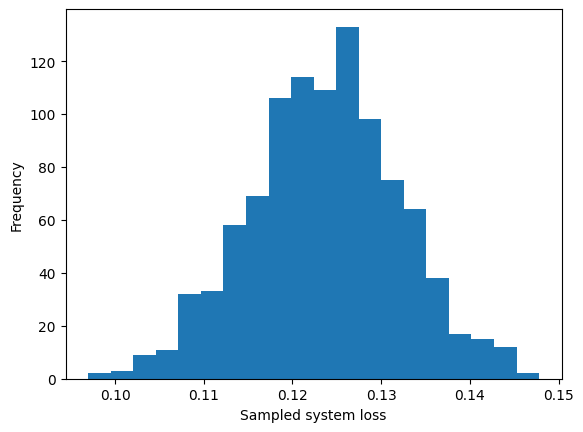

number of system calls:  1000
time taken for system evaluation:  241.635573387146
best loss:  tensor(0.0970, dtype=torch.float64)
target loss: tensor([0.0340, 0.0028, 0.0091, 0.0112, 0.0001], dtype=torch.float64)
reached loss: tensor([[3.6693e-01, 6.2442e-03, 4.2433e-03, 1.0668e-02, 1.6096e-04]],
       dtype=torch.float64)
candidate param:  tensor([[0.2330, 0.0200, 0.0315, 0.0251, 0.0008]], dtype=torch.float64)
time taken for one BO iteration:  295.4299783706665
BO iteration:  20
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  53.32930016517639
1000


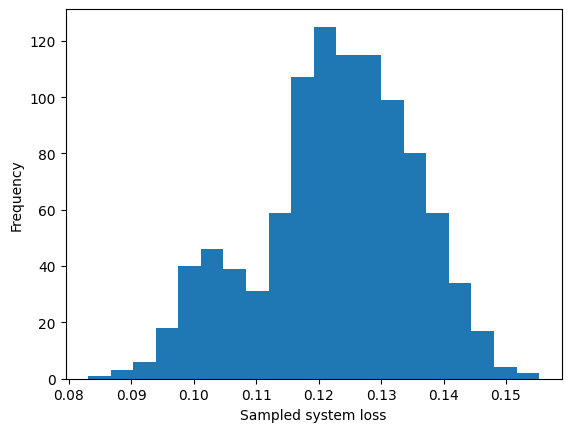

number of system calls:  1000
time taken for system evaluation:  243.87865257263184
best loss:  tensor(0.0831, dtype=torch.float64)
target loss: tensor([0.2330, 0.0200, 0.0315, 0.0251, 0.0008], dtype=torch.float64)
reached loss: tensor([[0.2336, 0.3865, 0.0336, 0.0271, 0.0008]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.0340, 0.0028, 0.0829, 0.1020, 0.0001]], dtype=torch.float64)
time taken for one BO iteration:  298.54977440834045
BO iteration:  21
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  51.105305194854736
1000


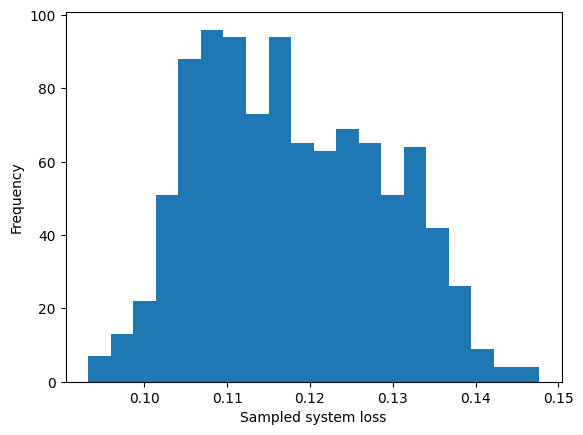

number of system calls:  1000
time taken for system evaluation:  233.24169039726257
best loss:  tensor(0.0932, dtype=torch.float64)
target loss: tensor([0.0340, 0.0028, 0.0829, 0.1020, 0.0001], dtype=torch.float64)
reached loss: tensor([[6.4216e-02, 3.8639e-01, 7.7561e-02, 1.0707e-01, 1.4433e-04]],
       dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.0340, 0.0028, 0.0091, 0.0112, 0.0013]], dtype=torch.float64)
time taken for one BO iteration:  285.67662620544434
BO iteration:  22
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  53.18856644630432
1000


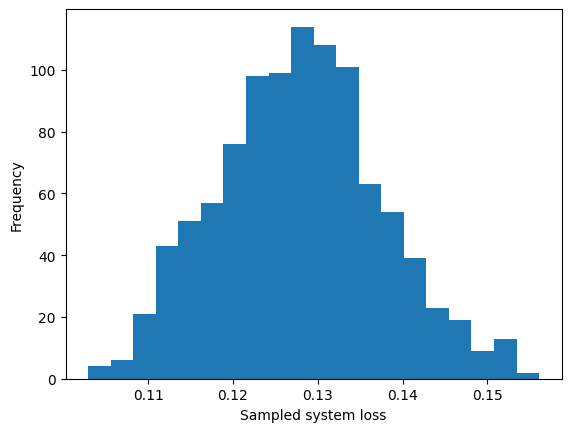

number of system calls:  1000
time taken for system evaluation:  244.91731452941895
best loss:  tensor(0.1029, dtype=torch.float64)
target loss: tensor([0.0340, 0.0028, 0.0091, 0.0112, 0.0013], dtype=torch.float64)
reached loss: tensor([[0.0298, 0.0003, 0.0096, 0.0116, 0.0015]], dtype=torch.float64)
candidate param:  tensor([[0.1630, 0.0041, 0.0255, 0.0644, 0.0002]], dtype=torch.float64)
time taken for one BO iteration:  298.90040731430054
BO iteration:  23
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  51.770024061203
1000


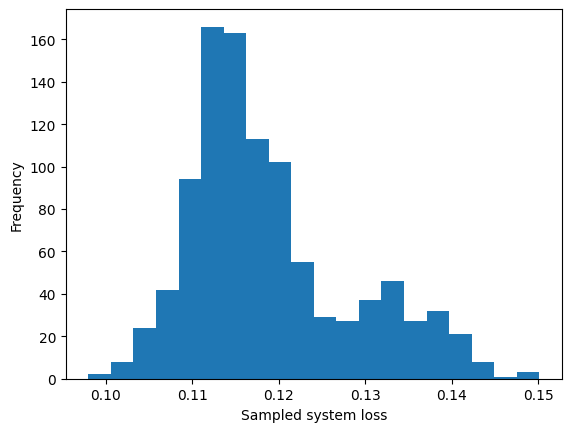

number of system calls:  1000
time taken for system evaluation:  249.31906628608704
best loss:  tensor(0.0980, dtype=torch.float64)
target loss: tensor([0.1630, 0.0041, 0.0255, 0.0644, 0.0002], dtype=torch.float64)
reached loss: tensor([[0.1598, 0.0018, 0.0344, 0.0670, 0.0002]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.0340, 0.0028, 0.0829, 0.0112, 0.0001]], dtype=torch.float64)
time taken for one BO iteration:  302.2802269458771
BO iteration:  24
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  50.713651180267334
1000


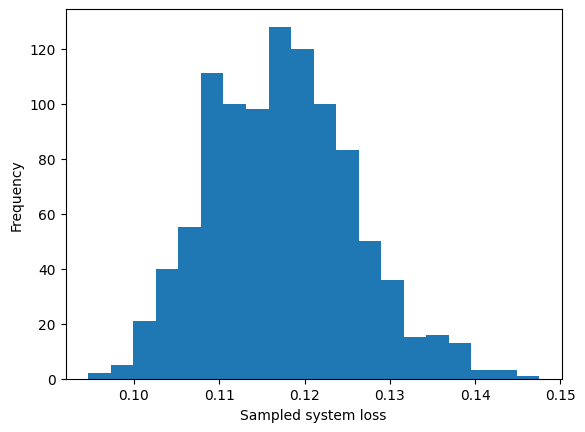

number of system calls:  1000
time taken for system evaluation:  239.53334283828735
best loss:  tensor(0.0946, dtype=torch.float64)
target loss: tensor([0.0340, 0.0028, 0.0829, 0.0112, 0.0001], dtype=torch.float64)
reached loss: tensor([[0.0299, 0.0014, 0.0821, 0.0108, 0.0001]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.3090, 0.0028, 0.0829, 0.1020, 0.0013]], dtype=torch.float64)
time taken for one BO iteration:  292.32574248313904
BO iteration:  25
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  50.22653555870056
1000


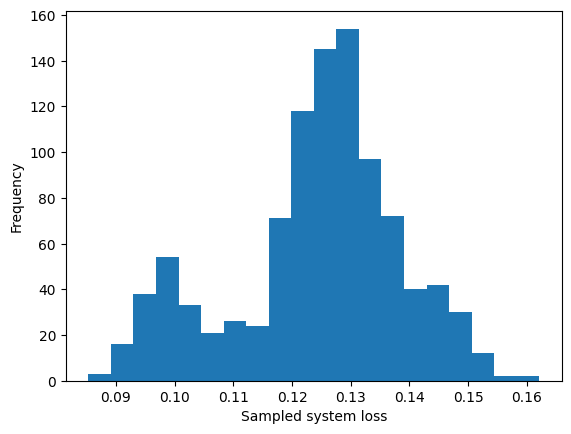

number of system calls:  1000
time taken for system evaluation:  228.1395559310913
best loss:  tensor(0.0853, dtype=torch.float64)
target loss: tensor([0.3090, 0.0028, 0.0829, 0.1020, 0.0013], dtype=torch.float64)
reached loss: tensor([[0.3671, 0.0011, 0.0815, 0.1033, 0.0014]], dtype=torch.float64)
candidate param:  tensor([[0.2125, 0.0081, 0.0451, 0.0752, 0.0004]], dtype=torch.float64)
time taken for one BO iteration:  279.2194652557373
BO iteration:  26
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  52.08269190788269
1000


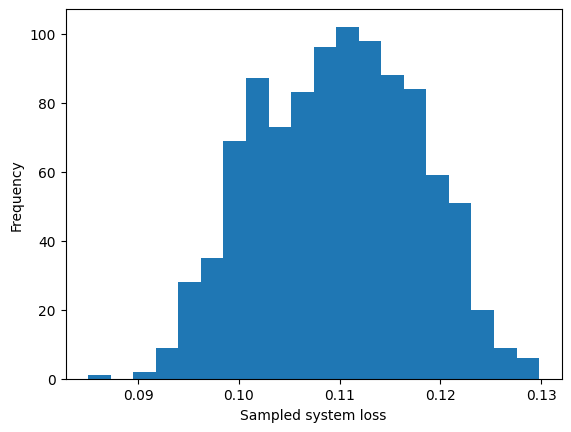

number of system calls:  1000
time taken for system evaluation:  229.9722123146057
best loss:  tensor(0.0850, dtype=torch.float64)
target loss: tensor([0.2125, 0.0081, 0.0451, 0.0752, 0.0004], dtype=torch.float64)
reached loss: tensor([[0.2085, 0.0036, 0.0495, 0.0824, 0.0004]], dtype=torch.float64)
candidate param:  tensor([[0.1684, 0.0148, 0.0218, 0.0279, 0.0012]], dtype=torch.float64)
time taken for one BO iteration:  284.32803106307983
BO iteration:  27
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  49.83766031265259
1000


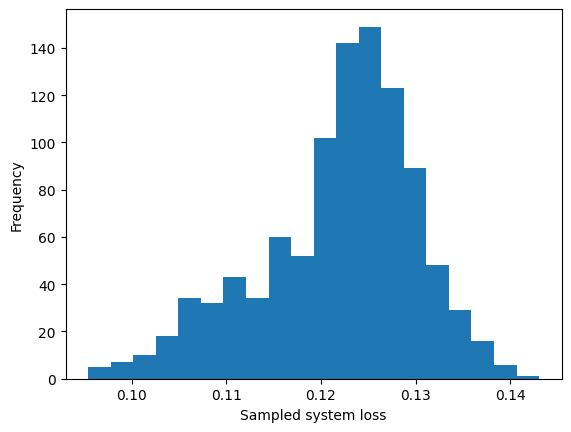

number of system calls:  1000
time taken for system evaluation:  246.107483625412
best loss:  tensor(0.0954, dtype=torch.float64)
target loss: tensor([0.1684, 0.0148, 0.0218, 0.0279, 0.0012], dtype=torch.float64)
reached loss: tensor([[0.1653, 0.0112, 0.0239, 0.0255, 0.0013]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[3.0905e-01, 2.8308e-03, 8.2914e-02, 1.0196e-01, 1.4633e-04]],
       dtype=torch.float64)
time taken for one BO iteration:  296.779470205307
BO iteration:  28
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  50.98107957839966
1000


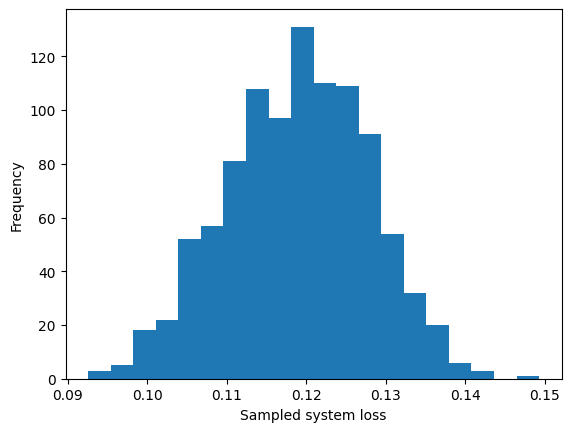

number of system calls:  1000
time taken for system evaluation:  236.1156153678894
best loss:  tensor(0.0926, dtype=torch.float64)
target loss: tensor([3.0905e-01, 2.8308e-03, 8.2914e-02, 1.0196e-01, 1.4633e-04],
       dtype=torch.float64)
reached loss: tensor([[3.0316e-01, 3.8641e-01, 8.7953e-02, 1.0598e-01, 1.5478e-04]],
       dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[0.0340, 0.0028, 0.0829, 0.0112, 0.0013]], dtype=torch.float64)
time taken for one BO iteration:  288.21422290802
BO iteration:  29
Current best objective:  tensor(-0.0824, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  50.326008796691895
1000


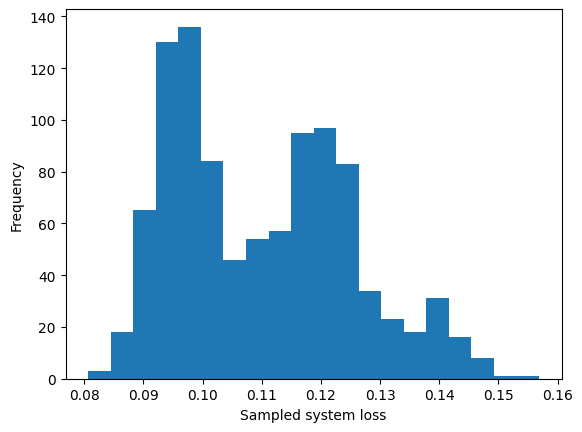

number of system calls:  1000
time taken for system evaluation:  229.24478268623352
best loss:  tensor(0.0807, dtype=torch.float64)
target loss: tensor([0.0340, 0.0028, 0.0829, 0.0112, 0.0013], dtype=torch.float64)
reached loss: tensor([[0.0238, 0.0014, 0.0766, 0.0115, 0.0014]], dtype=torch.float64)
MODEL FITTING, THROW
candidate param:  tensor([[3.0905e-01, 2.8308e-03, 8.2914e-02, 1.0196e-01, 1.4633e-04]],
       dtype=torch.float64)
time taken for one BO iteration:  280.52701210975647
1


NameError: name 'candidate_loss_all' is not defined

In [8]:
our_bo_trial = 1
loss_space_bo_all_trials = []
#lower_bound_local_loss = np.array([[0.04690535], [4.3721084e-05], [0.00128291], [0.00230525], [0.01456002], [4.15571211e-05], [0.00304988], [0.00065909], [0.03127085], [0.11541819], [0.07509221], [0.0516401]]).flatten()l
for x in range(50):
    print("number of attempts: ", x)
    print("trial of our BO (successful): ", len(loss_space_bo_all_trials))
    if len(loss_space_bo_all_trials) >= our_bo_trial:
        break
    
    dg_nn.random_initialize_param(15)      
    bounds = torch.tensor([np.array(lower_bound_local_loss) * 1.1, np.array(lower_bound_local_loss) * 10])
    all_best_losses_ours, best_param = BO_graph_local_loss(dg_nn, bounds, "nn_lookup", samples=1000, iteration=30)
    loss_space_bo_all_trials.append(all_best_losses_ours)

    
loss_space_bo_all_trials = np.array(loss_space_bo_all_trials)
np.savetxt("result/mnist_testing.csv", loss_space_bo_all_trials)

In [ ]:
print(x)

In [3]:
import torch
from torch.special import *
from Models.Model import Model
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np



class Net(nn.Module):
    def __init__(self, output_size):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(128*7*7, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            #nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

class ModelMNIST(Model):
    def __init__(self, local_train_loader : DataLoader, system_train_loader : DataLoader, output_size = 10, lr=0.003, tol = 1e-05, dtype=torch.float64):
        super().__init__(lr=lr, tol=tol, dtype = dtype)
        # if torch.cuda.is_available():
        #     self.conv_model = Net(output_size).to("cuda:0")
        self.conv_model = Net(output_size)
        self.local_train_loader = local_train_loader
        for batch_idx, (input, target) in enumerate(local_train_loader):
            self.X = input
            self.y = target
            break
        self.oracle_mode = False
    
    def is_nn(self):
        return True
    
    def nn_function(self):
        return
    
    def set_oracle_mode(self, bool_val):
        self.oracle_mode = bool_val

    def evaluate_score(self, x):
        return self.conv_model.forward(x)

    def evaluate(self, x):
        device = torch.device("cpu")
        if self.oracle_mode:
            return x # input will be just the label
        result = self.conv_model.forward(x.to(device)).max(1,keepdim=False)[1]
        return result
    
    def get_params(self):
        return [None]
    
    def test(self):
        print("hello")
    
    def get_local_loss(self):
        self.conv_model.eval()
        loss = 0

        data, target = self.X, self.y
        data = data.unsqueeze(1)
        
        # if torch.cuda.is_available():
        #     data = data.cuda()
        #     target = target.cuda()
        
        output = self.conv_model(data)
        
        criterion = nn.CrossEntropyLoss()
        cross_entropy_loss = criterion(output, target)
        loss += cross_entropy_loss

        return loss
    
    def do_one_descent_on_local(self):
        optimizer = optim.Adam(params=self.conv_model.parameters(), lr=0.0003)
        exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        self.conv_model.train()
        
        data, target = self.X, self.y
        data = data.unsqueeze(1)
    
        # if torch.cuda.is_available():
        #     data = data.cuda()
        #     target = target.cuda()
        
        optimizer.zero_grad()
        output = self.conv_model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
                
    def descent_to_target_loss(self, target_loss):
        def my_loss(output, target, target_loss):
            criterion = nn.CrossEntropyLoss()
            cross_entropy_loss = criterion(output, target)
            return (target_loss - cross_entropy_loss)**2
        
        optimizer = optim.Adam(params=self.conv_model.parameters(), lr=0.005)
        exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        self.conv_model.train()
        exp_lr_scheduler.step()
        data, target = self.X, self.y
        data = data.unsqueeze(1)
        data, target = data, target
    
        # if torch.cuda.is_available():
        #     data = data.cuda()
        #     target = target.cuda()
        
        # number of iteration
        for x in range(200):
            optimizer.zero_grad()
            output = self.conv_model(data)
            loss = my_loss(output, target, target_loss)
            loss.backward()
            optimizer.step()

    def random_initialize_param(self, seed=None):
        if seed is None:
            torch.manual_seed(np.random.randint(0,1000000))
        else:
            torch.manual_seed(seed)
        @torch.no_grad()
        def weight_reset(m: nn.Module):
            # - check if the current module has reset_parameters & if it's callabed called it on m
            reset_parameters = getattr(m, "reset_parameters", None)
            if callable(reset_parameters):
                m.reset_parameters()
                    
        self.conv_model.apply(fn=weight_reset)

In [ ]:
conv_model = Net(output_size)

for parameter in conv_model.parameters():
    print(parameter)

In [9]:
conv_model = Net(2)

for parameter in conv_model.conv_block.parameters():
    print(len(parameter))
    
for parameter in conv_model.linear_block.parameters():
    print(len(parameter))

32
32
64
64
128
128
128
128
64
64
2
2
